O Acidente Vascular Cerebral (AVC), também conhecido como derrame cerebral, é uma das principais causas de morte e incapacidade em todo o mundo. Ele ocorre quando o fluxo sanguíneo para uma parte do cérebro é interrompido, privando as células cerebrais de oxigênio e nutrientes vitais.  
Isso pode levar à morte das células cerebrais em poucos minutos, resultando em danos permanentes ao cérebro e a possibilidade de paralisia, dificuldade na fala e outras complicações graves.  
Esse problema tem grande prevalência no Brasil, e tem aumentado, em especial entre os mais jovens, segundo reportagem do R7 saúde.  
O objetivo desse trabalho é criar um modelo classificador para tentar, a partir de algumas features, classificar se uma certa pessoa teve ou não AVC. Caso ele apresente boa acúracia, pode-se compreender alguns fatores que são mais determinantes para causar um AVC. Os modelos utilizados foram árvore de decisão e gradiente descendente.

Fontes:
https://noticias.r7.com/saude/proporcao-de-jovens-que-morrem-de-avc-no-brasil-aumenta-em-2021-29102021

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad
import numpy as np

O primeiro passo realizado para lidar com os dados foi baixar e ler a base de dados do kaggle (disponível em: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), seguido da categorização de dados numéricos e transformação em one-hot-encoding. 


In [2]:
df = pd.read_csv('dados_avc.csv')
df.head(2)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


Como pode-se perceber, as features (dados de entrada do modelo) não estão padronizadas. Exsitem elementos numéricos nas colunas "age", "avg_glucose_level" e "bmi", que serão categorizadas. Os critérios para as categorias foram baseados em agumas pesquisas na internet. As fontes estão disponíveis nos comentários do código.

In [3]:
# Preencher valores ausentes em 'bmi' com a média
df['bmi'].replace('N/A', float('nan'), inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
# Criar faixas etárias
age_bins = [0, 18, 35, 60, 100]
age_labels = ['Criança/Adolescente', 'Jovem', 'Adulto', 'Idoso']
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Criar categorias de IMC
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ['Abaixo do peso', 'Peso normal', 'Sobrepeso', 'Obesidade']
df['bmi'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# Criar níveis de glicose no sangue
glucose_bins = [0, 70, 130, 200, 900]
glucose_labels = ['Baixo', 'Normal', "Alto", 'Muito alto']
df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

# Converter colunas categóricas usando one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','avg_glucose_level', 'bmi', 'age'], drop_first=True)
df.head(2)

,id,hypertension,heart_disease,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,9046,0,1,1,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
1,51676,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,1


Com o dataframe pronto, foi realizada a separação para o dataframe X (features) e Y (resultado). No caso em questão, as features eram idade, bmi, hipertensão, tipo de trabalho, entre outros, ao passo que o resultado é ter tido, ou não, AVC. 

In [4]:
X = df.drop(['stroke', 'id'], axis=1)
Y = df['stroke']
X.head(1)

,hypertension,heart_disease,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,0,1,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1


Antes de realizar as manipulações de fato, são realizadas algumas operações apenas para homogeneizar os dados (todos os false viraram -1, bem como os 0), para permitir a análise. Além disso, foi escolhido -1 ou 1 para que todos os fatores estivessem na mesma escala, permitindo uma comparação mais simples e clara. 

In [5]:
## converting the 0 to -1
X = X.replace(0, -1)

## convering the True to 1 and False to -1
Y = Y.replace(0, -1)
X = X.replace(True, 1)
X = X.replace(False, -1)

X = X.astype('float64')
Y = Y.astype('float64')

Em seguida, foi a separação de dataset de treino e teste. Inicialmente, foi realizada uma divisão convencional, com 30% dos dados para treino e o restante para teste. Contudo, após realizar as análises do modelo e da hipótese nula, percebeu-se que a quantidade de casos de AVC era pouco significativa no dataset, acarretando nos modelos enviesados e escolhendo -1 (sem AVC) como saída. Com isso em mente, foi realizado um novo treinamento coletando todos os 249 casos com AVC e 251 dos restantes para montar o novo dataset. Esse dataset com 500 pessoas foi dividido 50% para treino e o restante para teste.

In [6]:
X = X[:500]
Y = Y[:500]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)


Após a separação do dataset, foi desenvolvido o código da função de perda. A ideia utilizada nessa implementação é que, existe uma “linha” que consegue dividir os dados em dois grupos: “teve AVC” e “não teve AVC”. Para determinar essa linha, inicia-se com um chute inicial e esse valor vai sendo melhorado conforme é realizado o “gradiente descendente” da função de perda. Basicamente busca-se a direção que maximiza o erro e percorre-se a direção contrária. Após várias iterações, a “linha” passa a ficar próxima o suficiente da ideal, com os menores erros possíveis (ou pelo menos próxima o suficiente do menor valor do mínimo local). Matematicamente temos:
$$ y = w_t x + b $$ 
Em que y é a classificação calculada pelo modelo, $w_t$ é o vetor de pesos das features, x é o vetor com features de cada pessoa e b é o “bias” (viés). 


In [7]:
def loss( parametros ):
    w, b, x, y = parametros
    est = w.T @ x + b
    mse = np_.mean( (est - y)**2)
    return mse

g = grad(loss)
x = np.array(X_train).T
y = np.array(Y_train)


In [8]:
w = np.random.randn(x.shape[0], 1)
b = 0.0
alpha = 10**-2

for n in range(20000):
    grad_ = g( (w, b, x, y) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]


In [9]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred[Y_pred > 0] = 1
Y_pred[Y_pred <= 0] = -1

In [10]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

## create tuples with value of w and X column name
w_tuples = []
w_lin_model = []
for i in range(len(w)):
    w_tuples.append((w[i][0], X.columns[i]))
    w_lin_model.append((model.coef_[i], X.columns[i]))

## sort the tuples
w_tuples.sort(reverse=True)
w_lin_model.sort(reverse=True)


In [11]:
print(w_tuples)

x = np.array(X_test).T
y = np.array(Y_test)

y_est = w.T @ x + b
print(f"Acurácia do modelo: {accuracy(y, y_est) * 100:.2f}%")

print(w_lin_model)

print(accuracy_score(Y_test, Y_pred))

[(0.5582977632269354, 'age_Idoso'), (0.30558717704915184, 'age_Adulto'), (0.18408314433300554, 'smoking_status_formerly smoked'), (0.17753516120663826, 'hypertension'), (0.10802915909190465, 'avg_glucose_level_Normal'), (0.10776850330316119, 'smoking_status_smokes'), (0.07964451221466773, 'bmi_Sobrepeso'), (0.07515591346439782, 'heart_disease'), (0.0705245172039135, 'gender_Male'), (0.06084809376581988, 'work_type_Private'), (0.05944169445619412, 'work_type_children'), (0.05847837852361168, 'avg_glucose_level_Alto'), (0.04238967905378174, 'smoking_status_never smoked'), (0.03673097295758454, 'Residence_type_Urban'), (0.028682084998195943, 'avg_glucose_level_Muito alto'), (-0.010883340230238835, 'work_type_Self-employed'), (-0.011084644229985886, 'ever_married_Yes'), (-0.031444735168841706, 'work_type_Never_worked'), (-0.05450486809049891, 'bmi_Peso normal'), (-0.09835365475807442, 'bmi_Obesidade'), (-0.11324670141649928, 'age_Jovem'), (-0.4403946365670758, 'gender_Other')]
Acurácia do 

In [12]:
def avaliar_hipotese_nula(y_test):
    return max(np.count_nonzero(y_test == 1), np.count_nonzero(y_test == -1)) / len(y_test)

In [13]:
print(avaliar_hipotese_nula(y_test= Y.to_numpy()))

0.502


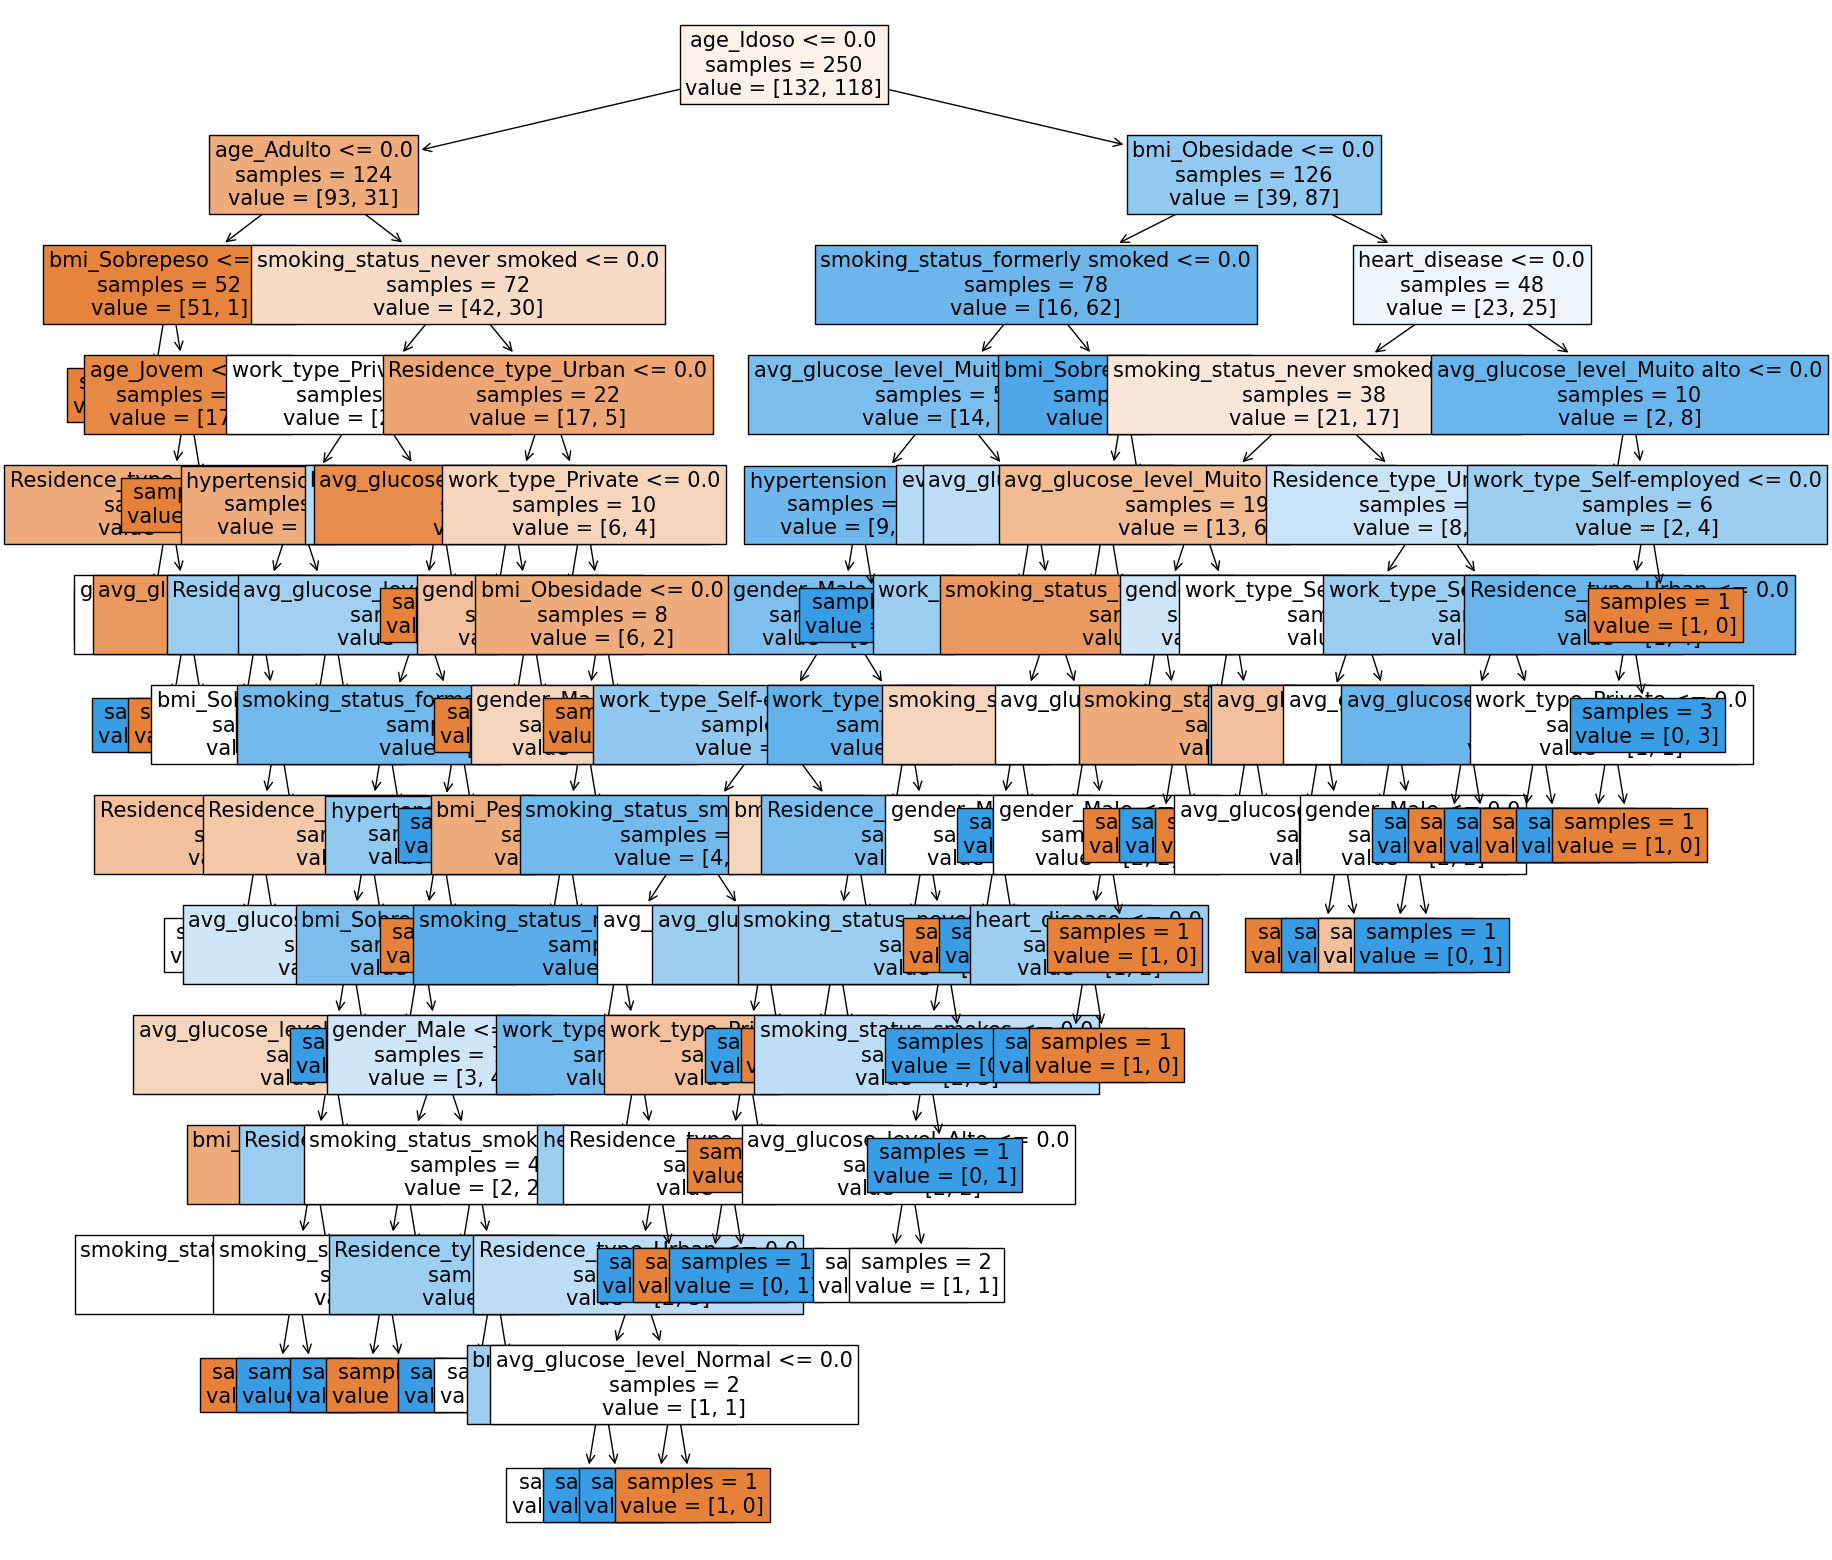

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy')

# Agora, vamos usar o método .fit() para ajustar os parâmetros da árvore:
tree.fit(X_train, Y_train)

# Podemos visualizar a árvore de decisão em uma figura!
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

In [15]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Acurácia do modelo de árvore de decisão:", accuracy)


Acurácia do modelo de árvore de decisão: 0.62


In [16]:
import pandas as pd

# Obter importância das características
feature_importances = tree.feature_importances_

# Criar DataFrame com as features e sua importância
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar o DataFrame pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Exibir o DataFrame
print(feature_importance_df)


                           Feature  Importance
21                       age_Idoso    0.157644
20                      age_Adulto    0.099353
13        avg_glucose_level_Normal    0.091345
9             Residence_type_Urban    0.074511
2                      gender_Male    0.057402
6                work_type_Private    0.056539
15    avg_glucose_level_Muito alto    0.054826
17                   bmi_Sobrepeso    0.054427
0                     hypertension    0.051585
18                   bmi_Obesidade    0.044694
10  smoking_status_formerly smoked    0.043265
14          avg_glucose_level_Alto    0.040484
1                    heart_disease    0.037179
11     smoking_status_never smoked    0.036408
7          work_type_Self-employed    0.032961
12           smoking_status_smokes    0.029553
16                 bmi_Peso normal    0.021336
19                       age_Jovem    0.010086
4                 ever_married_Yes    0.006401
8               work_type_children    0.000000
5           w